In [1]:
from lammps import PyLammps

In [58]:
import numpy as np
from scipy.optimize import leastsq
from tqdm import tqdm

echo log
units		metal
atom_style 	atomic
boundary	p p p #sss

In [46]:
def initialize():
    L = PyLammps()
    L.command("echo log")
    L.command("units metal")
    L.command("atom_style atomic")
    L.command("boundary p p p")
    return L

In [44]:
def set_lattice(L, structure, alat, reps):
    L.lattice("%s %f orient x 1 0 0 orient y 0 1 0 orient z 0 0 1"%(structure, alat))
    L.region("box block 0 %d 0 %d 0 %d"%(reps[0], reps[1], reps[2]))
    L.create_box("1 box")
    L.create_atoms("1 box")
    return L

In [45]:
def set_potential(L, potfile, mass):
    L.pair_style("sw")
    L.pair_coeff("* * %s Si"%potfile)
    L.neighbor("1.0 bin")
    L.neigh_modify("every 1 delay 1 check yes")
    L.mass("* %f"%mass)
    return L

In [59]:
def routine_energy(simdict, return_volume = False):
    L = initialize()
    L = set_lattice(L, simdict["structure"], simdict["alat"], simdict["reps"])
    L = set_potential(L, simdict["potfile"], simdict["mass"])
    L.run(1)
    pe = L.eval('pe')/L.system.natoms
    if return_volume:
        vol = L.eval('vol')/L.system.natoms
        return pe, vol
    else:
        return pe

In [53]:
def routine_lattice_constant(simdict):
    L = initialize()
    L = set_lattice(L, simdict["structure"], simdict["alat"], simdict["reps"])
    L = set_potential(L, simdict["potfile"], simdict["mass"])
    L.minimize(" 1.0e-8 1.0e-8 100000000 100000000")
    vol = L.eval('vol')/(simdict["reps"][0]*simdict["reps"][1]*simdict["reps"][2])
    lat = vol**(1/3)
    return lat

In [79]:
simdict = {"structure": "diamond", "alat": 5.43, "reps":[2,2,2], "potfile": "test.sw", "mass":35.46}

In [51]:
routine_energy(simdict)

LAMMPS output is captured by PyLammps wrapper


-4.33659613839015

In [54]:
routine_lattice_constant(simdict)

LAMMPS output is captured by PyLammps wrapper


5.429999999999999

In [55]:
def birch_murnaghan(vol, ene):
    a, b, c = np.polyfit(vol, ene, 2)
    V0 = -b/(2*a)
    E0 = a*V0**2 + b*V0 + c
    B0 = 2*a*V0
    Bp = 4.0
    eta = (vol/V0)**(1.0/3.0)
    E = E0 + 9.0*B0*V0/16.0 * (eta**2-1.0)**2 * (6.0 + Bp*(eta**2-1.0) - 4.0*eta**2)
    return E

In [80]:
def routine_ev_curve(msimdict, variation = 0.01, points=100):
    simdict = msimdict.copy()
    alat = simdict["alat"]
    alats = np.linspace((1-variation)*alat, (1+variation)*alat, points)
    energies = []
    volumes = []
    for c, val in tqdm(enumerate(alats)):
        simdict["alat"] = val
        e, v = routine_energy(simdict, return_volume= True)
        energies.append(e)
        volumes.append(v)
    #now fit
    efit = birch_murnaghan(volumes, energies)
    return volumes, energies, efit

In [83]:
volumes, energies, efit = routine_ev_curve(simdict)

23it [00:00, 225.33it/s]

LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLam

100it [00:00, 277.08it/s]

LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLam

In [62]:
import matplotlib.pyplot as plt

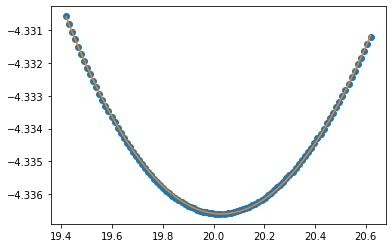

In [84]:
plt.plot(volumes, energies, 'o')
plt.plot(volumes, efit, '-')

In [34]:
L.eval('pe')/L.system.natoms

6.753941330979168

["WARNING: Using 'neigh_modify every 1 delay 0 check yes' setting during minimization (../min.cpp:168)",
 'Setting up cg style minimization ...',
 '  Unit style    : metal',
 '  Current step  : 3',
 'Per MPI rank memory allocation (min/avg/max) = 4.311 | 4.311 | 4.311 Mbytes',
 'Step Temp E_pair E_mol TotEng Press ',
 '       3            0    13832.072            0    13832.072    6302222.8 ',
 '     103            0    3746.2683            0    3746.2683      4878282 ',
 'Loop time of 3.72343 on 1 procs for 100 steps with 2048 atoms',
 '',
 '100.0% CPU use with 1 MPI tasks x no OpenMP threads',
 '',
 'Minimization stats:',
 '  Stopping criterion = max iterations',
 '  Energy initial, next-to-last, final = ',
 '         13832.0718458      3752.77181051      3746.26827075',
 '  Force two-norm initial, final = 2.60535e-12 24.6334',
 '  Force max component initial, final = 2.31988e-13 1.73836',
 '  Final line search alpha, max atom move = 0.0207959 0.0361508',
 '  Iterations, force evalu

TypeError: 'PyLammps' object is not subscriptable